# Tracking stars in the night sky

In this tutorial, we'll see how to use *covalent* to manage all the tasks involved in tracking the position of a star in the users' night sky. Stars and other celestial objects have coordinates distributed on the celestial sphere, a projected sphere surrounding the Earth, and tracking celestial objects means transforming celestial coordinates into Earth coordinates at a particular location.

The `covalent` library enables us to construct a workflow from all of the individual functions, or substacks, involved in our computation. The final results are collected by the covalent results manager, including the results of each substack. We can use this to track the performance or each sustack in our workflow, and optimize or correct errors as necessary. 

The required packages and corresponding versions are as follows:

In [1]:
with open("./requirements.txt", "r") as file:
    for line in file:
        print(line.rstrip())


covalent
matplotlib==3.4.3
pytz==2022.1


In [2]:
# Install required packages
# !pip install -r ./requirements.txt


We start by importing the Covalent library as well as all other packages we'll need for our star tracker and for visualizing our results.

In [3]:
from datetime import date, datetime

import matplotlib.pyplot as plt
import numpy as np
import pytz

import requests

import covalent as ct


Tracking the motion of a particular star (or galaxy, nebula, etc.) across your local horizon is not a trivial task. It involves a lot of steps to transform the stellar coordinates into Earth sky coordinates and track the position of the star at the desired location and date. Our goal is to input a list of stars we want to track as well as our local region and coordinates to find the altitude and azimuth of the selected stars on our night sky. This can be used to check whether the stars will be visible at all, when they will be at their maximum position on our local horizon, and where they will appear. 

We break this process down into the following substacks that are constructed using the [Covalent electron](../../api/api.rst#covalent.electron) decorator (called using @ct.electron).

1. `get_RA`: uses an API to fetch the right ascension (RA) of all stars on the target list. RA is then converted from hours, minutes, and seconds into degrees.
2. `get_dec`: uses the same API to fetch the declination (dec) of all stars on the target list. Dec is converted from degrees, minutes, and seconds into degrees.
3. `days_since_J2000`: calculates the number of days that have passed since January 1st, 2000 A.D., or J2000. This is necessary because J2000 is used as a fundamental epoch, from which time measurements - such as sidereal time - are often measured. This takes **region** as an input; it's important to specify a particular city so that the correct time zone is identified. Some example regions are 'America/Los_Angeles' and 'Europe/Paris'.
4. `local_sidereal_time`: given the **days since J2000**, the **local longitude**, and the **time** measured in Universal Time, this function calculates the local sidereal time of the observer on the current date.
5. `hour_angle`: given the **local sidereal time** and the **right ascencion** in degrees, this function calculates the hour angle. It characterizes the difference between the Earth's surface and the celestial sphere.
6. `altitude_of_target`: calculates the altitude of the target in the observer's sky given the **declination** in degrees, the local **latitude**, and the **hour angle**. 
7. `convert_to_utc`: converts the local **region**'s 24-hour day range starting from 0h to 24h to UTC.
8. `get_date`: returns the current date at the user's location given their **region**.
9. `get_azimuth`: calculates the azimuth angle, measured from North (0 degrees) towards East, given the **declination** in degrees, the local **latitude**, the **hour angle**, and the **altitude**.

In [5]:
@ct.electron
def get_RA(target_list):
    RA = []
    for target_name in target_list:
        response = requests.get(
            "http://simbad.u-strasbg.fr/simbad/sim-id?output.format=votable&Ident=%s&output.params=ra,dec"
            % target_name
        )
        star_info = response.text
        RA.append(star_info[star_info.index("<TR><TD>") + 8 : star_info.index("</TD><TD>")])
    RA_degs = []
    for source in RA:
        hour = float(source.split(" ")[0])
        minute = float(source.split(" ")[1])
        second = float(source.split(" ")[2])
        RA_degs.append(((hour + minute / 60 + second / 3600) * 15))
    return RA_degs


@ct.electron
def get_dec(target_list):
    dec = []
    for target_name in target_list:
        response = requests.get(
            "http://simbad.u-strasbg.fr/simbad/sim-id?output.format=votable&Ident=%s&output.params=ra,dec"
            % target_name
        )
        star_info = response.text
        dec.append(star_info[star_info.index("</TD><TD>") + 9 : star_info.index("</TD></TR>")])
    dec_degs = []
    for source in dec:
        degree = float(source.split(" ")[0])
        arcmin = float(source.split(" ")[1])
        arcsec = float(source.split(" ")[2])
        if degree < 0:
            dec_degs.append(degree - arcmin / 60 - arcsec / 3600)
        else:
            dec_degs.append(degree + arcmin / 60 + arcsec / 3600)
    return dec_degs


@ct.electron
def days_since_J2000(region):
    f_date = date(2000, 1, 1)
    year = get_date(time_zone=region)[0]
    month = get_date(time_zone=region)[1]
    day = get_date(time_zone=region)[2]
    l_date = date(year, month, day)
    delta = l_date - f_date
    return delta.days


@ct.electron
def local_sidereal_time(d, long, T):
    LST = 100.46 + 0.985647 * (d + T / 24) + long + 15 * T
    return LST


@ct.electron
def hour_angle(LST, RA):
    LST_list = []
    for source in RA:
        LST_list.append(np.asarray([value - source for value in LST]))
    return LST_list


@ct.electron
def altitude_of_target(dec, lat, ha):
    alt_list = []
    lat = lat * 0.0174533
    for i in range(len(dec)):
        dec_i = dec[i] * 0.0174533
        ha_i = ha[i] * 0.0174533
        alt = np.arcsin(np.sin(dec_i) * np.sin(lat) + np.cos(dec_i) * np.cos(lat) * np.cos(ha_i))
        alt_list.append(alt * 57.2958)
    return alt_list


@ct.electron
def convert_to_utc(time_zone):
    start_time = 0
    end_time = 24.016
    now = datetime.now(pytz.timezone(time_zone))
    offset = now.utcoffset().total_seconds() / 60 / 60
    utc_timerange = np.arange(start_time - offset, end_time - offset, 0.016)
    return utc_timerange


@ct.electron
def get_date(time_zone):
    now = datetime.now(pytz.timezone(time_zone))
    year = now.year
    month = now.month
    day = now.day
    return [year, month, day]


@ct.electron
def get_azimuth(dec, lat, ha, alt):
    az_list = []
    lat = round(lat * 0.0174533, 2)
    for i in range(len(dec)):
        azimuth = []
        dec_i = round(dec[i] * 0.0174533, 2)
        ha_i = ha[i] * 0.0174533
        alt_i = alt[i] * 0.0174533
        a = np.arccos(
            (np.sin(dec_i) - np.sin(alt_i) * np.sin(lat)) / (np.cos(alt_i) * np.cos(lat))
        )
        for q in range(len(ha_i)):
            if np.sin(ha_i[q]) < 0:
                azimuth.append(a[q] * 57.2958)
            else:
                azimuth.append(360 - (a[q] * 57.2958))
        az_list.append(np.array(azimuth))
    return az_list


Now that all of the necessary substacks are defined, we can create the workflow using the [covalent lattice](https://covalent.readthedocs.io/en/latest/api/api.html#lattices-api) decorator, called with `@ct.lattice`. The workflow, `final_calc`, takes a list of stars to be observed, the time zone region, and the local latitude and longitude. It strings together all of the transformations and calculations necessary to locate the targets on the observer's sky. It returns arrays of altitude and azimuth values for each star on the target list. 

In the below example, the target list includes the binary star system Sirius as well as the ultracool dwarf star TRAPPIST-1. The local time zone is America/Los Angeles, and local coordinates are for Vancouver, British Columbia.

In [6]:
@ct.lattice
def final_calc(
    target_list=["sirius", "trappist-1"],
    region="America/Los_Angeles",
    latitude=49.2827,
    longitude=-123.1207,
):
    RA = get_RA(target_list=target_list)
    dec = get_dec(target_list=target_list)
    T = convert_to_utc(time_zone=region)
    d = days_since_J2000(region=region)
    lst = local_sidereal_time(d=d, long=longitude, T=T)
    ha = hour_angle(LST=lst, RA=RA)
    alt = altitude_of_target(dec=dec, lat=latitude, ha=ha)
    az = get_azimuth(dec=dec, lat=latitude, ha=ha, alt=alt)
    return alt, az


Now that we've constructed our workflow from all of our substacks, we can visualize how they flow together and where there are interdependencies between subtasks.

In [ ]:
final_calc.draw(
    target_list=["sirius", "trappist-1"],
    region="America/Los_Angeles",
    latitude=49.2827,
    longitude=-123.1207,
)


Once you run the above codeblock, you can preview the workflow in the user interface (default at http://localhost:48008/preview) and see the generated graph which will look like this:

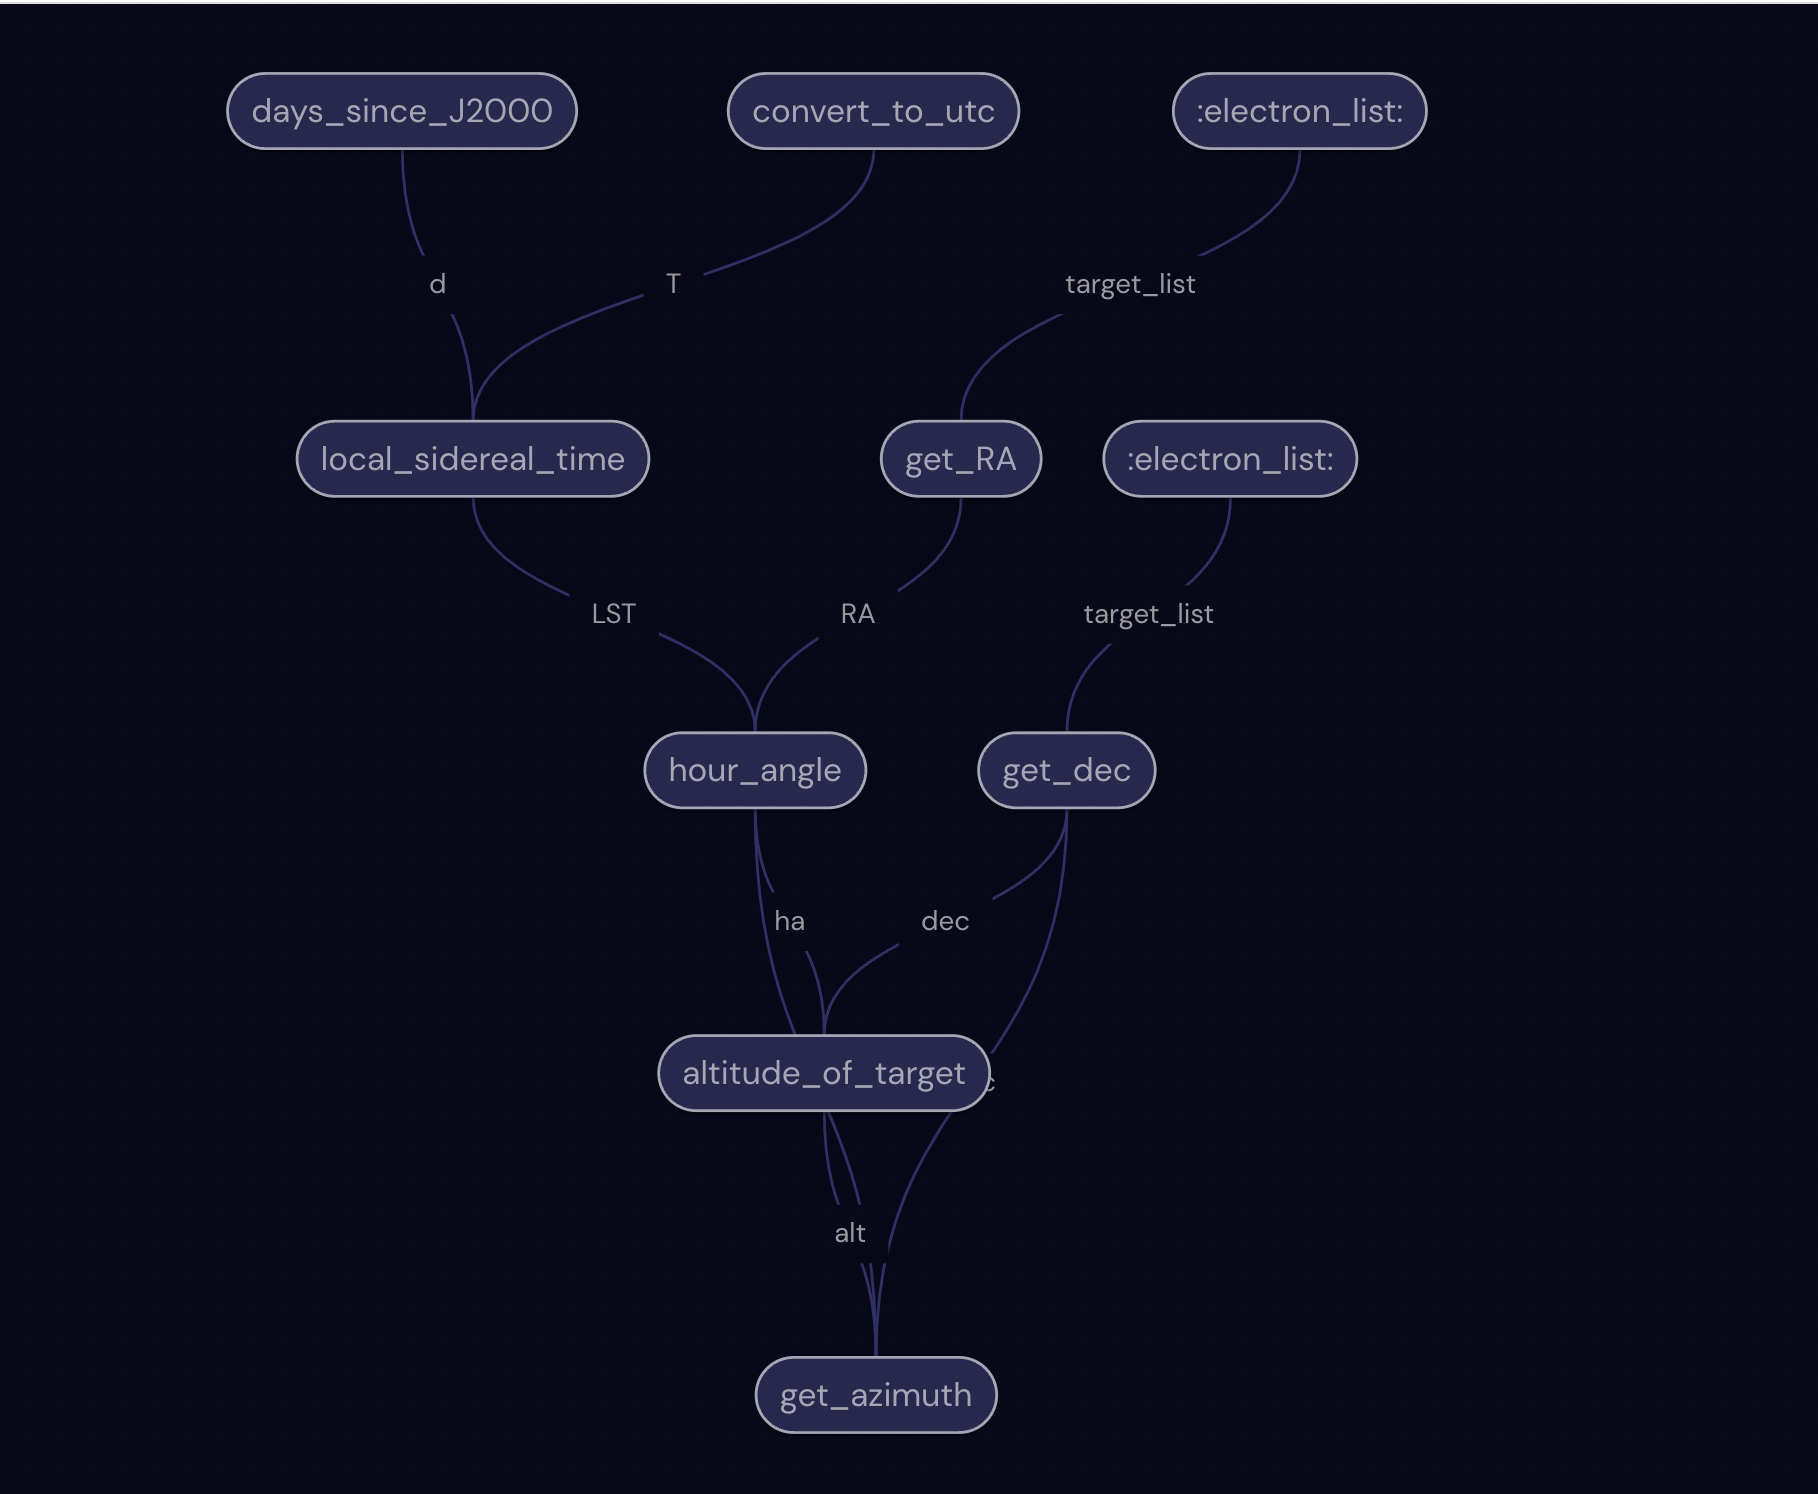

In [9]:
from IPython import display

display.Image("assets/final_calc.png")


The workflow can be executed using the `dispatch_sync` method, where the input parameters are specified in the lattice function above. The results - the altitude and azimuth values for all targets on the list - are available immediately.

In [10]:
altitude_azimuth = ct.dispatch_sync(final_calc)()
print(altitude_azimuth.result)


([array([-39.84123324, -39.69690029, -39.55231697, ..., -39.53838193,
       -39.39352781, -39.24842998]), array([33.48520074, 33.54249525, 33.59907637, ..., 33.60448683,
       33.66028316, 33.71536121])], [array([66.52329269, 66.75779268, 66.99153335, ..., 67.01400043,
       67.24691611, 67.47908605]), array([158.99648346, 159.28294404, 159.57001082, ..., 159.59768472,
       159.88542276, 160.17377973])])


We can take a look at the results from all seven subtasks that went into calculating the local altitude and azimuth. Since quite a few subtasks are dependent on the results of other subtasks, this is a convenient way to track where an error originates.

## Visualizing our Results

Our results include arrays of altitude and azimuth values collected approximately every minute through a 24-hour period, for all stars on our target list. This information can be difficult to process by itself, so there are a few useful ways to visualize these results. 

First, we can plot the altitude of our target on our local horizon. This will tell us how high above the horizon our target will be located - an altitude of 0&deg; is located exactly on the horizon, while an altitude of 90&deg; is located at zenith, or directly overhead. A negative altitude means that our star is below our horizon, and is not visible at the current time. The function `plotting_altitude` takes an array of altitude values, and plots them with local 24-hour time on the x-axis. For Sirius, the altitude values are output in the first result, in the first array, and can be called using *target_altitude = altitude_azimuth.result[0][0]*. The below plot shows us the altitude of Sirius local to Vancouver.

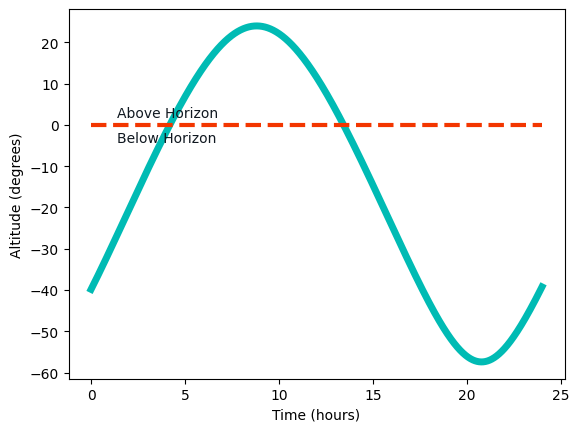

In [11]:
def plotting_altitude(target_altitude=altitude_azimuth.result[0][0]):
    T_local = np.arange(0, 24.016, 0.016)
    plt.plot(T_local, target_altitude, color="#00BBB4", linewidth=5, alpha=1)
    plt.ylabel("Altitude (degrees)")
    plt.xlabel("Time (hours)")
    plt.hlines(y=0, xmin=0, xmax=24, color="#F33600", linestyles="--", linewidth=3)
    plt.text(x=1.4, y=1.8, s="Above Horizon", color="#101820")
    plt.text(x=1.4, y=-4.2, s="Below Horizon", color="#101820")
    plt.show()


plotting_altitude()


We can also visualize our results on our night sky by plotting a celestial sphere at a specified time of day, t. This visualization takes account of all targets in the list, using their altitude and azimuth to plot them on our local sky. Targets that appear above the horizon are plotted as green points, whereas targets that are below the horizon are plotted as green points. In this example, we choose 21h, or 9:00 P.M. in Vancouver.

147.33175858719315
76.3015989721232


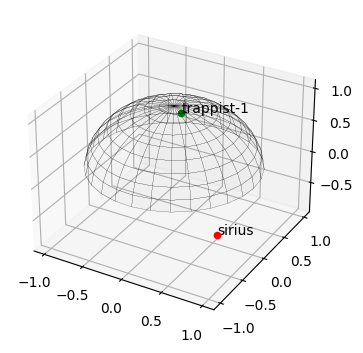

In [12]:
target_list = ["sirius", "trappist-1"]
# defining a 24 hour time period measured in local time
T_local = list(np.arange(0, 24.016, 0.016))

time = 21.00
# desired_time is the closest time in T_local to our input time (21.00)
desired_time = min(T_local, key=lambda x: abs(x - time))
idx = T_local.index(desired_time)

rad = 1.01
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(facecolor="w")
ax = fig.add_subplot(projection="3d")
r = 1.0
u, v = np.mgrid[0 : 2 * np.pi : 30j, 0 : np.pi : 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.abs(np.cos(v))
ax.plot_surface(x, y, z, edgecolors="k", linewidth=0.05, color="gray", alpha=0.01)
# plotting all stars on our target list
for i in range(len(target_list)):
    alt = 90 - list(altitude_azimuth.result[0][i])[idx]
    print(alt)
    az = list(altitude_azimuth.result[1][i])[idx]
    xx = rad * np.cos(az * 0.0174533) * np.sin(alt * 0.0174533)
    yy = rad * np.sin(az * 0.0174533) * np.sin(alt * 0.0174533)
    zz = rad * np.cos(alt * 0.0174533)
    if alt < 90:
        ax.scatter(xx, yy, zz, color="green")
    else:
        ax.scatter(xx, yy, zz, color="red")
    ax.text(xx, yy, zz, s=target_list[i])
plt.show()
